# Spectrograph Evaluation

Developed by Jiwon Jang (starrynight@snu.ac.kr) <br>
Updated at 2026.01.02. <br>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec

from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np

from numpy.polynomial.chebyshev import chebfit, chebval
from scipy.optimize import curve_fit
from scipy import odr
from scipy import interpolate
from scipy.interpolate import interp1d,CubicSpline, LSQUnivariateSpline
from scipy.signal import find_peaks, peak_widths

from astropy.io import fits
from astropy.table import Table
from astropy.stats import gaussian_fwhm_to_sigma, sigma_clip, sigma_clipped_stats
from astropy.modeling.models import Gaussian1D
from astropy.convolution import convolve, Gaussian1DKernel
from astropy.modeling.fitting import LevMarLSQFitter

In [3]:
import sys
from pathlib import Path

# Make sure the package folder (./spectrograph_eval) is discoverable
sys.path.insert(0, str(Path.cwd()))

from EvalSpec.units import WAVELENGTH_UNIT, angstrom_to_nm, nm_to_angstrom
from EvalSpec import (
    open_fits, Gaussian2D, gaussian,
    peak_detection, trace_spectrum, trace_fit, trace_profile,
    extract_profile)

print(f"Wavelength unit system: {WAVELENGTH_UNIT} (all wavelength arrays/labels follow this)")

Wavelength unit system: nm (all wavelength arrays/labels follow this)


**Note:** This notebook standardizes *all* wavelength-related values to **nm** (including calibration, reference lines, and figure labels). The helper functions used throughout the notebook are packaged under `./spectrograph_eval/`.

In [4]:
# set the params for plot
plt.rcParams['figure.figsize']=[5,5]
plt.rcParams['figure.facecolor'] = 'white'
#plt.rcParams['lines.linewidth']=2
plt.rcParams['font.size']=14
plt.rcParams['text.usetex']=False
plt.rcParams['axes.linewidth']=1.5
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.major.size']=7
plt.rcParams['ytick.major.size']=7
plt.rcParams['xtick.minor.size']=3.5
plt.rcParams['ytick.minor.size']=3.5
plt.rcParams['xtick.major.width']=1
plt.rcParams['ytick.major.width']=1
plt.rcParams['xtick.minor.width']=1
plt.rcParams['ytick.minor.width']=1
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.top']=True
plt.rcParams['legend.frameon']=False

In [5]:
root = Path("C:\\SNU\\Internship\\Data\\IsoPlane320A")
data_path = root / "240824"
fig_path = Path("C:\\SNU\\Internship\\K-Spec\\논문\\FIgures")

# Load data files

In [6]:
objname = 'Vega'
grating = '150gr'
wavelength = ''#'_435nm'#'_650nm'
calib_flag = True

objdir = data_path / objname
dark_dir = data_path / 'Dark'
flat_dir = data_path / 'Tungsten\\Guide Unit'
calib_dir = data_path / 'ThAr\\Guide Unit'
ref_dir = root / "ref/ThAr.fits"
    
fig_dir = fig_path / 'On-Sky Test' / f'{objname}_{grating}{wavelength}'

if not fig_dir.exists(): fig_dir.mkdir()

sci_list = list(objdir.glob(f'*_{grating}{wavelength}*.fits'))
    
specidx = 0#2
hdr, sci = open_fits(sci_list[specidx])

#information from header
Ncol, Nrow = hdr['NAXIS1'],hdr['NAXIS2']
texp_sci = float(hdr['EXPTIME'])/1000

# Photometric Noise (Low Noise, High gain from CCD PTC measurment)
sigma_RDN = 15.42
G         = 1.12
P_FPN     = 0.295e-2

dark_sci_list = list(dark_dir.glob(f'Dark_{int(texp_sci)}s.fits'))
hdr_dark_sci, dark_sci = open_fits(dark_sci_list[0])

#Informations
print(f"Science: {hdr['NAXIS3']:d} frames / Exposure = {texp_sci:.1f}s")
print(f"Dark(Science): {hdr_dark_sci['NAXIS3']:d} frames")

#Median combine
master_sci = np.median(sci,axis=0)
master_dark_sci = np.median(dark_sci,axis=0)
sci_s = master_sci-master_dark_sci

if calib_flag:
    calib_list = list(calib_dir.glob(f'Calibration_ThAr_{grating}{wavelength}*.fits'))
    flat_list = list(flat_dir.glob(f'Flat_{grating}{wavelength}*.fits'))

    hdr_calib, calib = open_fits(calib_list[0])
    hdr_flat, flat = open_fits(flat_list[0])

    texp_calib = float(hdr_calib['EXPTIME'])/1000
    texp_flat = float(hdr_flat['EXPTIME'])/1000

    dark_calib_list = list(dark_dir.glob(f'Dark_{int(texp_calib)}s.fits'))
    dark_flat_list = list(dark_dir.glob(f'Dark_{int(texp_flat)}s.fits'))

    hdr_dark_calib, dark_calib = open_fits(dark_calib_list[0])
    hdr_dark_flat, dark_flat  = open_fits(dark_flat_list[0])

    print(f"Wavelength Calibration(ThAr): {hdr_calib['NAXIS3']:d} frames / Exposure = {texp_calib:.1f}s")
    print(f"Flat(Tungsten): {hdr_flat['NAXIS3']:d} frames / Exposure = {texp_flat:.1f}s")
    print(f"Dark(Calibration): {hdr_dark_calib['NAXIS3']:d} frames")
    print(f"Dark(Flat): {hdr_dark_flat['NAXIS3']:d} frames")
    
    master_flat = np.median(flat,axis=0)
    master_calib = np.median(calib,axis=0)
    master_dark_calib = np.median(dark_calib,axis=0)
    master_dark_flat = np.median(dark_flat,axis=0)

    calib_s = master_calib-master_dark_calib
    flat_s = master_flat-master_dark_flat

Science: 5 frames / Exposure = 1.0s
Dark(Science): 9 frames
Wavelength Calibration(ThAr): 3 frames / Exposure = 120.0s
Flat(Tungsten): 5 frames / Exposure = 60.0s
Dark(Calibration): 9 frames
Dark(Flat): 9 frames


In [14]:
# Spectral Range
lam_cen  = 600 # nm
disp = 18.4 # nm /mm
w_px = 20e-3 # mm
span = disp*w_px*Ncol
print(f'Range = {lam_cen-span/2:.2f}-{lam_cen+span/2:.2f}[nm] (Span = {span}nm)')

Range = 353.44-846.56[nm] (Span = 493.12nm)


# Reference Spectrum - Standard Star

In [7]:
std_path = root / "standard_spectra\\CALSPEC"
std_list = list(std_path.glob('*.fits'))
std_list

[WindowsPath('C:/SNU/Internship/Data/IsoPlane320A/standard_spectra/CALSPEC/10lac_stis_007.fits'),
 WindowsPath('C:/SNU/Internship/Data/IsoPlane320A/standard_spectra/CALSPEC/16cygb_stis_005.fits'),
 WindowsPath('C:/SNU/Internship/Data/IsoPlane320A/standard_spectra/CALSPEC/alpha_lyr_stis_011.fits'),
 WindowsPath('C:/SNU/Internship/Data/IsoPlane320A/standard_spectra/CALSPEC/delumi_stis_005.fits'),
 WindowsPath('C:/SNU/Internship/Data/IsoPlane320A/standard_spectra/CALSPEC/etauma_stis_007.fits')]

In [9]:
idx = 2
spec_tab = Table.read(std_list[idx])# Table
header = fits.getheader(std_list[idx], ext=0) #Header

tgt_id = header['TARGETID']
lam_mask = ((spec_tab['WAVELENGTH']>3500)&(spec_tab['WAVELENGTH']<=9000))
std_lam = spec_tab[lam_mask]['WAVELENGTH']  # Å
std_flux = spec_tab[lam_mask]['FLUX']  # erg s^-1 cm^-2 Å^-1 (converted from per-)
std_fluxerr = spec_tab[lam_mask]['STATERROR']
# unit conversion
if WAVELENGTH_UNIT=='nm': std_lam/=10.0; std_flux*=10.0; std_fluxerr*=10.0
print(tgt_id)

HD172167


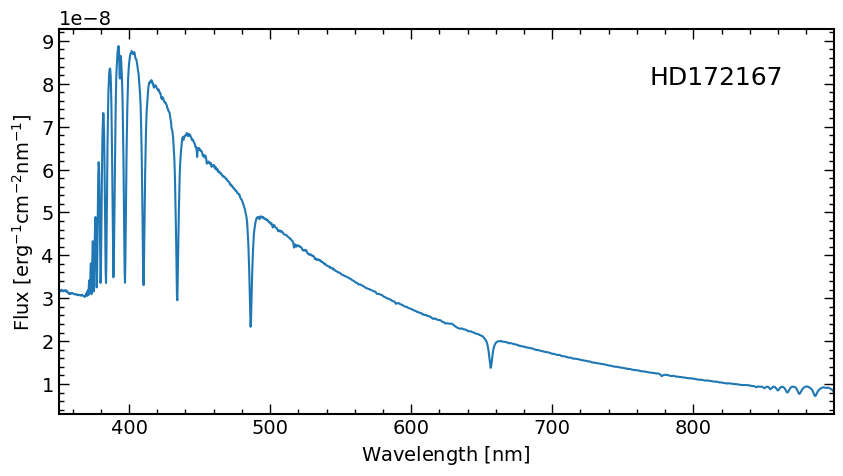

In [11]:
plt.figure(figsize=(10,5))
plt.plot(std_lam,std_flux)
plt.xlim(std_lam[0],std_lam[-1])
plt.text(std_lam[-1]*0.96,max(std_flux)*0.9,s=f'{tgt_id}',horizontalalignment='right',fontsize=18)
if WAVELENGTH_UNIT=='nm':
    plt.xlabel('Wavelength [$\\rm nm$]')
    plt.ylabel('Flux [$\\rm erg^{-1}cm^{-2}nm^{-1}$]')
else:
    plt.xlabel('Wavelength [$\\rm \\AA$]')
    plt.ylabel('Flux [$\\rm erg^{-1}cm^{-2}\\AA^{-1}$]')

# Spectrum tracing

https://learn.astropy.org/tutorials/1-SpectroscopicTraceTutorial.html

In [13]:
nspec=1
yi, yf = 640,660

In [14]:
FWHM_AP = 10
step_AP = 10
N_AP = Ncol//step_AP
pixel = np.arange(0, Ncol)  # dispersion axis pixel
tr_deg = 4  # order of trace polynomial

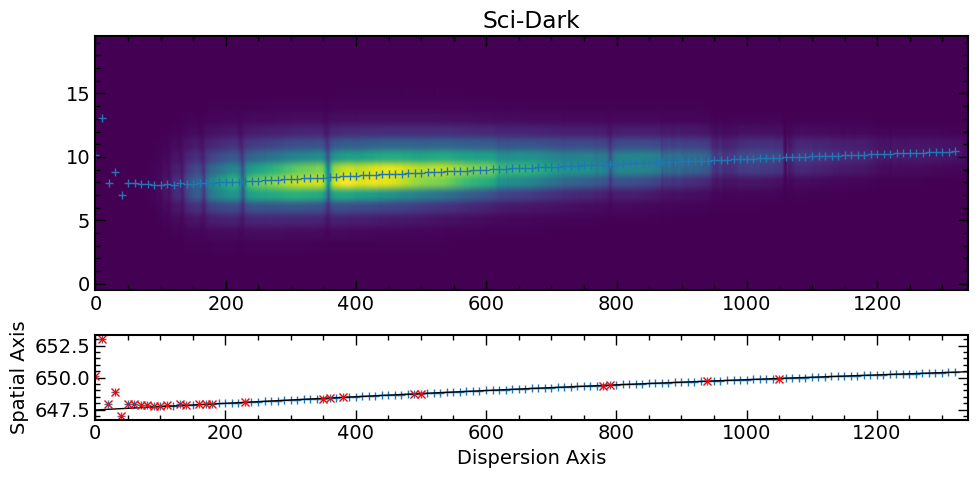

In [15]:
xpos, trace, fwhm, params = trace_profile(
    sci_s, nspec=nspec, bound=(yi, yf), label='Sci-Dark', fit=True,
    fwhm_ap=FWHM_AP, step_ap=step_AP, deg=tr_deg
)
#plt.savefig(fig_dir / 'sci_trace.png', dpi=300, bbox_inches="tight")


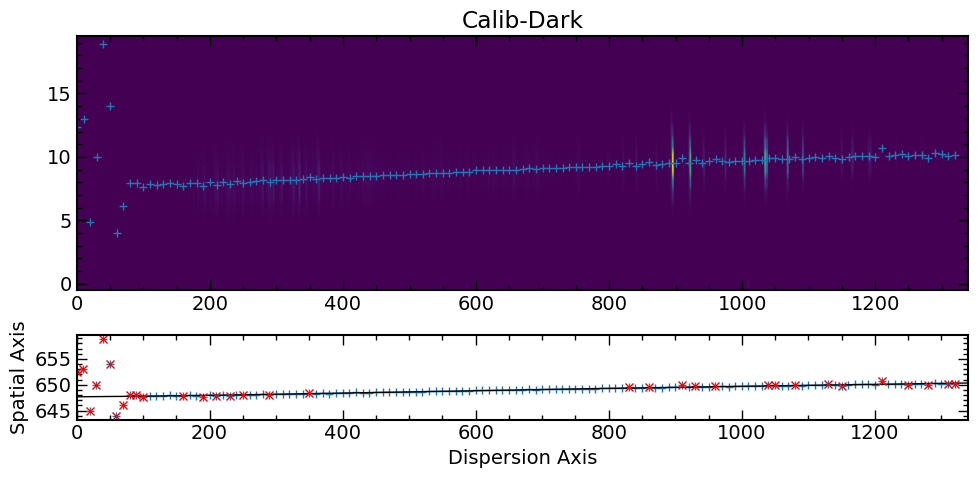

In [17]:
xpos, trace, fwhm, params = trace_profile(
    calib_s, nspec=nspec, bound=(yi, yf), label='Calib-Dark', fit=True,
    fwhm_ap=FWHM_AP, step_ap=step_AP, deg=tr_deg
)

## Extract 1D spectra

In [16]:
profile, sci_spec, sci_e_spec, trace_center = extract_profile(
    sci_s, texp_sci, nspec=nspec, bound=(yi, yf),
    width=5, rdn=sigma_RDN, gain=G, fpn=P_FPN,
    fwhm_ap=FWHM_AP, step_ap=step_AP)

sci_spec = sci_spec[0]

if calib_flag:
    calib_profile, calib_spec, calib_e_spec, calib_trace_center = extract_profile(
        calib_s, texp_calib, nspec=nspec, bound=(yi, yf),
    width=5, rdn=sigma_RDN, gain=G, fpn=P_FPN,
    fwhm_ap=FWHM_AP, step_ap=step_AP)

    calib_spec = calib_spec[0]

# Wavelengh Calibrarion

## 1) Wavelength Calibration with Balmer lines

In [20]:
max_order = 7  # H-(max_order)
# Reference line list in **nm** (values below are commonly used Balmer lines; originally in Å)
balmer = np.array([3750, 3771, 3798, 3835, 3889.064, 3970.079, 4101.742, 4340.471, 4861.333, 6562.819]) 
telluric = np.array([5895.92, 5889.95, 6867.19, 7593.70])
ref_lines = np.hstack([balmer[-max_order:]])  # , telluric])
if WAVELENGTH_UNIT=='nm': ref_lines/=10

In [22]:
peaks_sci, _ = find_peaks(-sci_spec/max(sci_spec), prominence=0.001, distance=10)

# Pixel-to-wavelength initial guess (all in **nm**)
pixtolam = pixel*0.395 + 343.0   # initial guess (150gr)  [0.395 nm/px, 343 nm offset]
#pixtolam = pixel*0.194 + 375.0  # initial guess (300gr)
#pixtolam = pixel*0.095 + 374.0  # initial guess (600gr, 435nm)
#pixtolam = pixel*0.095 + 589.0  # initial guess (600gr, 650nm)
#pixtolam = pixel*0.095 + 439.0  # initial guess (600gr, 500nm)

initial = pixtolam[peaks_sci]
peak_pos, nearest_ref = [], []
tol = 20.0 # A
if WAVELENGTH_UNIT=='nm': tol/=10.0
for i in range(len(peaks_sci)):
    delta = abs(initial[i] - ref_lines)
    dx, idx = np.min(delta), np.argmin(delta)
    if dx < tol:
        nearest_ref.append(ref_lines[idx])
        peak_pos.append(pixel[peaks_sci[i]])
peak_pos = np.array(peak_pos)

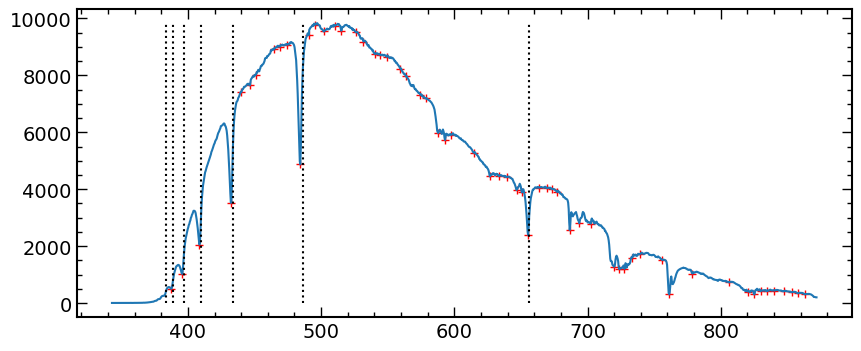

In [23]:
plt.figure(figsize=(10,4))
plt.plot(pixtolam[peaks_sci],sci_spec[peaks_sci],'r+')
plt.plot(pixtolam,sci_spec)
plt.vlines(ref_lines,ymin=0,ymax=max(sci_spec),ls='dotted',color='k')
#plt.xlim(3800,5200)

Text(0, 0.5, 'Res.[$\\rm nm$]')

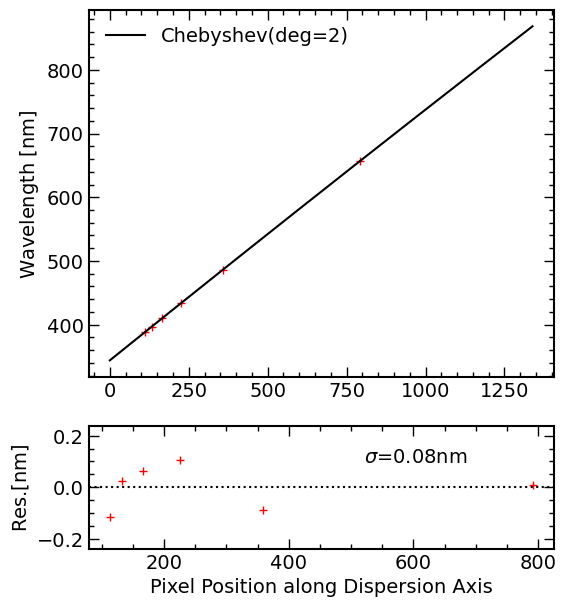

In [25]:
#Least Square Fitting - Chebyshev polynomial
wfit_deg = 2
p_wfit, fitfull = chebfit(peak_pos,nearest_ref,
                              deg=wfit_deg,full=True)
lams0 = chebval(pixel, p_wfit)
#wfit = np.polynomial.Chebyshev.fit(peak_pos,nearest_ref,deg=wpol_deg)
#lams = wfit(pixel)
dlam0 = lams0[1]-lams0[0]

gs = GridSpec(nrows=2,ncols=1,height_ratios=[3,1])
plt.figure(figsize=(6,7))
plt.subplot(gs[0])
plt.plot(peak_pos,nearest_ref,'r+')
plt.plot(pixel,lams0,color='k',label=f'Chebyshev(deg={wfit_deg})')
plt.ylabel('Wavelength [$\\rm nm$]')
#plt.xlim(450,1340)
#plt.ylim(500,900)
plt.legend()

plt.subplot(gs[1])
res0 = nearest_ref-chebval(peak_pos,p_wfit)
rmse0 = np.std(res0)
plt.plot(peak_pos,res0,'r+')
plt.axhline(0,ls='dotted',color='k')
plt.text(520,1.2*rmse0,f'$\\sigma$={rmse0:.2f}$\\rm nm$')
plt.ylim(-3*rmse0,3*rmse0)
plt.xlabel('Pixel Position along Dispersion Axis')
plt.ylabel('Res.[$\\rm nm$]')
#plt.savefig(fig_dir / 'wavelength_calib(Balmer).png',dpi=300, bbox_inches="tight")
#plt.tight_layout()

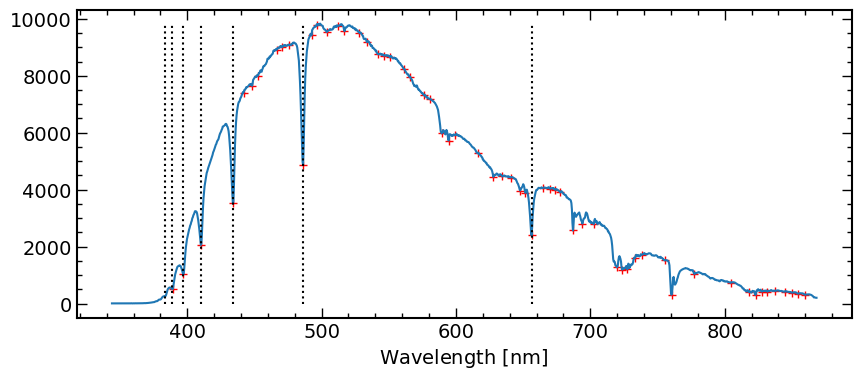

In [30]:
plt.figure(figsize=(10,4))
plt.plot(lams0[peaks_sci],sci_spec[peaks_sci],'r+')
plt.plot(lams0,sci_spec)
plt.vlines(ref_lines,ymin=0,ymax=max(sci_spec),ls='dotted',color='k')
if WAVELENGTH_UNIT=='nm': plt.xlabel('Wavelength [$\\rm nm$]')
else: plt.xlabel('Wavelength [$\\rm \\AA$]')
#plt.xlim(3500,5200)

## 2) Wavelength Calibration with Arc Lamp (ThAr)
https://noirlab.edu/science/data-services/other/spectral-atlas

In [27]:
#Load reference spectra (R=12000)
hdr_comp_ref, comp_ref = open_fits(ref_dir,dtype='float')
comp_ref_lam = (hdr_comp_ref['CRVAL1'] + np.arange(hdr_comp_ref['NAXIS1'])*hdr_comp_ref['CD1_1'])  # Angstrom
if WAVELENGTH_UNIT=='nm': comp_ref_lam/=10.0

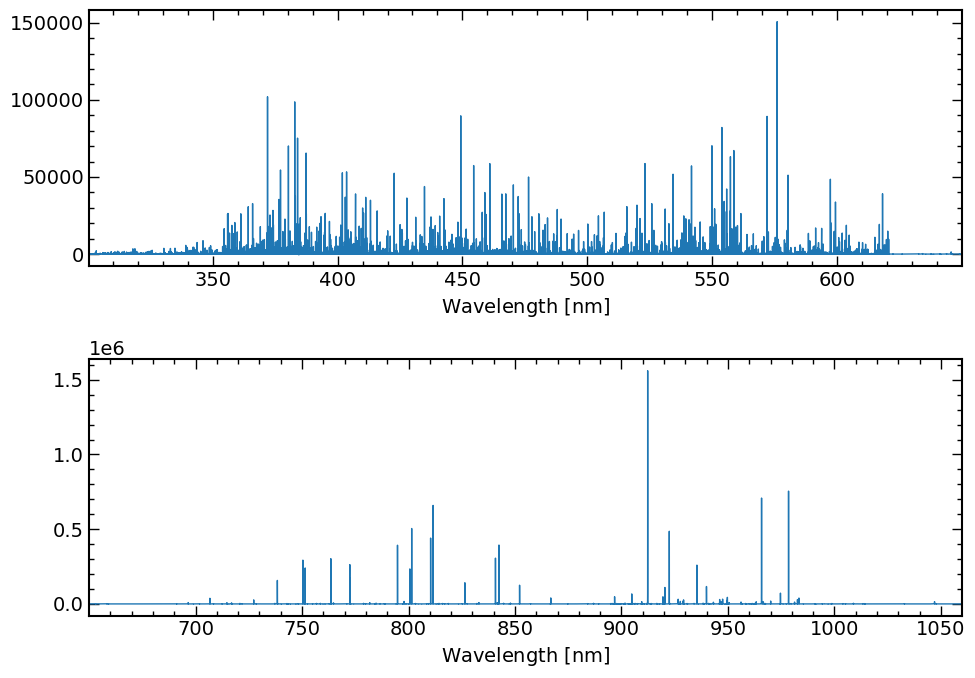

In [31]:
lam_ref_c = 6500 # Angstrom
if WAVELENGTH_UNIT=='nm': lam_ref_c/=10.0
#Reference
mask1 = (comp_ref_lam<=lam_ref_c)
mask2 = (comp_ref_lam>lam_ref_c)
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(comp_ref_lam[mask1],comp_ref[mask1],linewidth=1)
plt.xlim(comp_ref_lam[mask1][0],comp_ref_lam[mask1][-1])
if WAVELENGTH_UNIT=='nm': plt.xlabel('Wavelength [$\\rm nm$]')
else: plt.xlabel('Wavelength [$\\rm \\AA$]')

plt.subplot(2,1,2)
plt.plot(comp_ref_lam[mask2],comp_ref[mask2],linewidth=1)
plt.xlim(comp_ref_lam[mask2][0],comp_ref_lam[mask2][-1])
if WAVELENGTH_UNIT=='nm': plt.xlabel('Wavelength [$\\rm nm$]')
else: plt.xlabel('Wavelength [$\\rm \\AA$]')
plt.tight_layout()

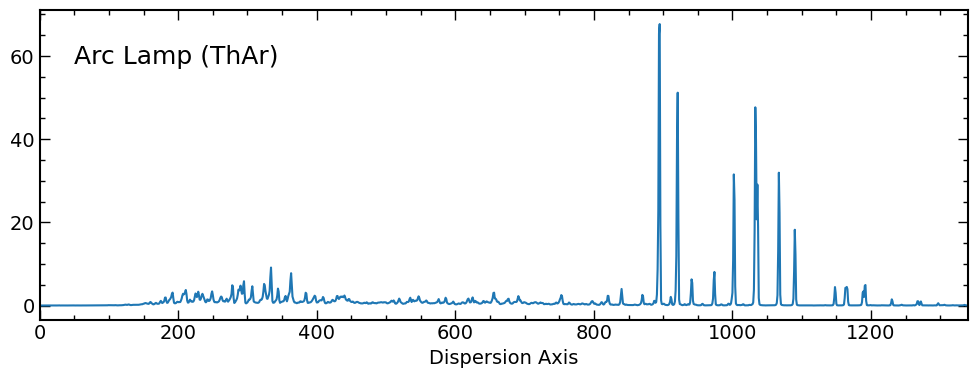

In [60]:
# Arc lamp spectrum (observed)
plt.figure(figsize=(10,4))
plt.plot(calib_spec)
plt.text(50,max(calib_spec)*0.86,s='Arc Lamp (ThAr)',fontsize=18)
plt.xlim(0,Ncol)
plt.xlabel('Dispersion Axis')
plt.tight_layout()

In [32]:
peaks,_ = find_peaks(calib_spec,height=1) #observed spectral peaks
#peaks_ref,_ = find_peaks(ref)#, prominence=0.001)
ref_pklam = comp_ref_lam#[peaks_ref]

initial = lams0[peaks] #+0.1*rmse0*np.random.random(len(peaks))
peak_pos, nearest_ref = [], []
tol = 1.0 # Angstrom
if WAVELENGTH_UNIT=='nm': tol/=10.0
for i in range(len(peaks)):
    delta = abs(initial[i]-ref_pklam)
    dx, idx = np.min(delta), np.argmin(delta)
    if dx<tol:
        nearest_ref.append(ref_pklam[idx])
        peak_pos.append(pixel[peaks[i]])
peak_pos = np.array(peak_pos)

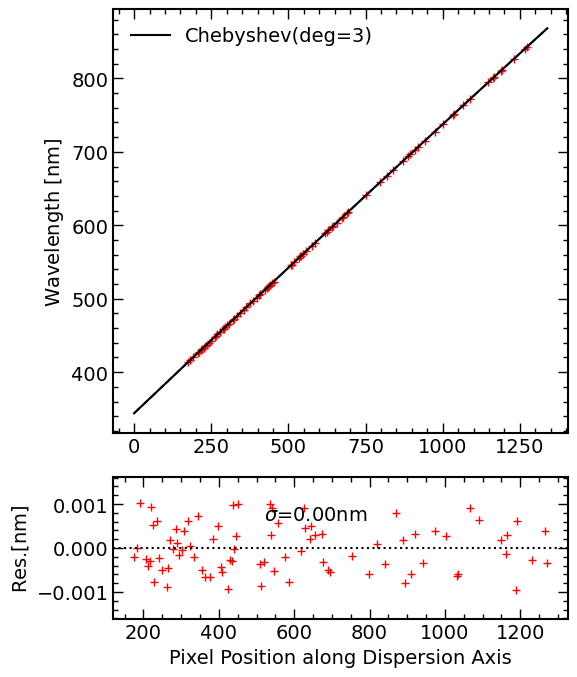

In [34]:
#Least Square Fitting - Chebyshev polynomial
wfit_deg = 3
p_wfit, fitfull = chebfit(peak_pos,nearest_ref,
                              deg=wfit_deg,full=True)
lams = chebval(pixel, p_wfit)
dlam = lams[1]-lams[0]

gs = GridSpec(nrows=2,ncols=1,height_ratios=[3,1])
plt.figure(figsize=(6,7))
plt.subplot(gs[0])
plt.plot(peak_pos,nearest_ref,'r+')
plt.plot(pixel, lams0, ls='--')
plt.plot(pixel,lams,color='k',label=f'Chebyshev(deg={wfit_deg})')
plt.ylabel('Wavelength [$\\rm nm$]')
#plt.xlim(450,1340)
#plt.ylim(500,900)
plt.legend()

plt.subplot(gs[1])
res = nearest_ref-chebval(peak_pos,p_wfit)
rmse = np.std(res)
plt.plot(peak_pos,res,'r+')
plt.axhline(0,ls='dotted',color='k')
plt.text(520,1.2*rmse,f'$\\sigma$={rmse:.2f}$\\rm nm$')
plt.ylim(-3*rmse,3*rmse)
plt.xlabel('Pixel Position along Dispersion Axis')
plt.ylabel('Res.[$\\rm nm$]')

plt.tight_layout()
#plt.savefig(fig_dir / 'wavelength_calib(ArcLamp).png',dpi=300, bbox_inches="tight")

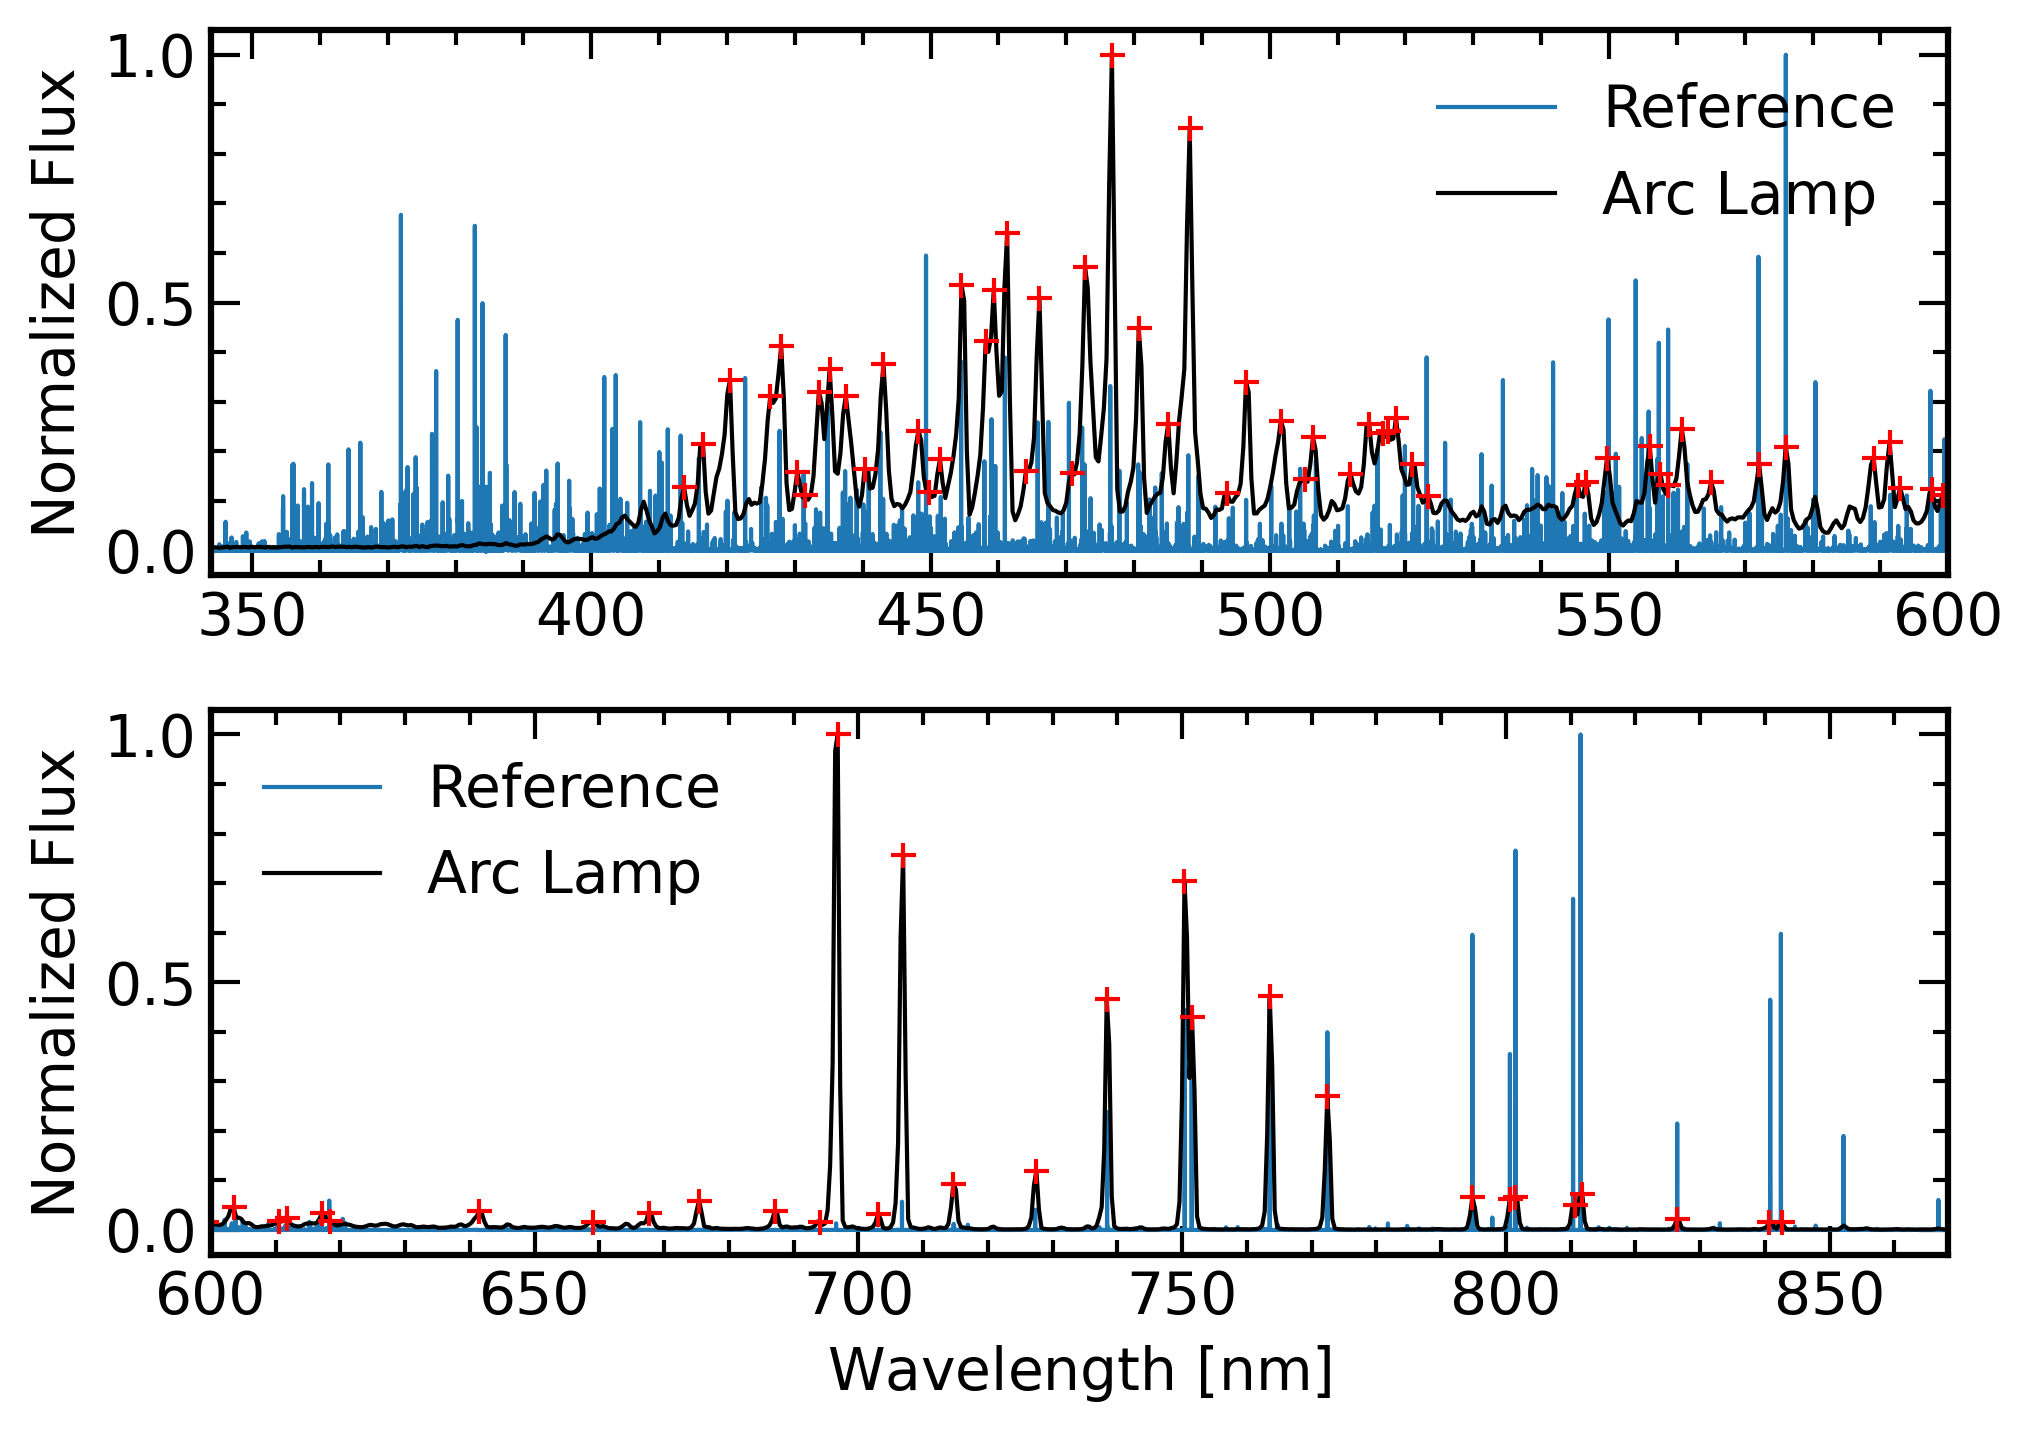

In [35]:
lamc = 6000
if WAVELENGTH_UNIT=='nm': lamc/=10.0
    
plt.figure(figsize=(7,5),dpi=300)
plt.subplot(2,1,1)
plt.plot(comp_ref_lam,comp_ref/max(comp_ref[comp_ref_lam<lamc]),lw=1,label='Reference')
plt.plot(lams,calib_spec/max(calib_spec[lams<lamc]),color='k',lw=1,label='Arc Lamp')
plt.plot(lams[peaks],calib_spec[peaks]/max(calib_spec[lams<lamc]),'r+')
#plt.xlabel('Wavelength [$\\rm nm$]')
plt.ylabel('Normalized Flux')
plt.xlim(lams[0],lamc)
plt.ylim(-0.05,1.05)
plt.legend()

plt.subplot(2,1,2)
plt.plot(comp_ref_lam,comp_ref/max(comp_ref[(comp_ref_lam>lamc)&(comp_ref_lam<lams[-1])]),lw=1,label='Reference')
plt.plot(lams,calib_spec/max(calib_spec[lams>lamc]),color='k',lw=1,label='Arc Lamp')
plt.plot(lams[peaks],calib_spec[peaks]/max(calib_spec[lams>lamc]),'r+')
#plt.xlabel('Wavelength [$\\rm nm$]')
plt.xlabel('Wavelength [$\\rm nm$]')
plt.ylabel('Normalized Flux')
plt.xlim(lamc,lams[-1])
plt.ylim(-0.05,1.05)
plt.legend()
plt.tight_layout()
#plt.savefig(fig_dir / 'wavecal_nm.png',dpi=300, bbox_inches="tight")

# Spectral Resolution

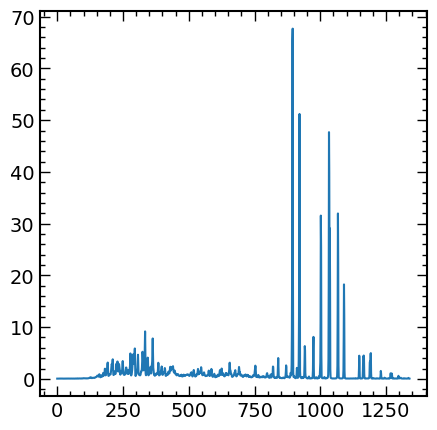

In [17]:
calib_profile, calib_spec, calib_e_spec, calib_trace_center = extract_profile(
        calib_s, texp_calib, nspec=nspec, bound=(yi, yf),
    width=5, rdn=sigma_RDN, gain=G, fpn=P_FPN,
    fwhm_ap=FWHM_AP, step_ap=step_AP)
calib_spec = calib_spec[0]
plt.plot(calib_spec)

## Spectral Resolution: empirical PSF-based

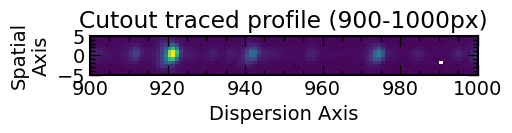

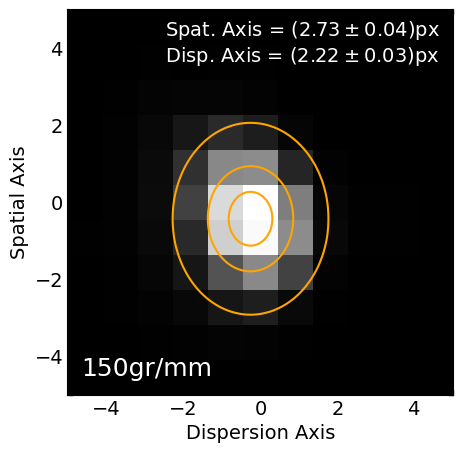

In [18]:
pi, pf =  900, 1000

plt.figure()
plt.title(f"Cutout traced profile ({pi}-{pf}px)")
plt.imshow(np.sqrt(calib_profile[0,pi:pf].T),extent=(pi,pf,-5,5)) #,vmin=0,vmax=20000,)
plt.xlabel('Dispersion Axis')
plt.ylabel('Spatial\nAxis')

peak_c = 921 #np.argmax(calib_spec)
wx = 5
peak_i, peak_f = peak_c - wx, peak_c+wx+1 
c_pixels = np.arange(-wx,wx+1)
xgrid, ygrid = np.meshgrid(c_pixels, c_pixels)
xs = np.linspace(-wx,wx,100)
Xs, Ys = np.meshgrid(xs, xs)

fig, ax = plt.subplots(1,1)#, figsize=(7,3.5))
popt, pcov = curve_fit(Gaussian2D,(xgrid,ygrid),calib_profile[0,peak_i:peak_f].T.reshape(-1))
perr = np.sqrt(np.diag(pcov))
pfit = Gaussian2D((Xs,Ys),*popt).reshape(len(xs),len(xs))
#ax.set_title('After Tracing')
ax.imshow(calib_profile[0,peak_i:peak_f].T,extent=(-5,5,-5,5),origin='lower',cmap='Greys_r')#,extent=(peak_i,peak_f,-5,5))
ax.contour(Xs, Ys, pfit,colors='orange',lw=0.5,levels=[popt[0]/10,popt[0]/2,popt[0]/1.2])
ax.set_xlabel('Dispersion Axis')
ax.set_ylabel('Spatial Axis')
ax.text(wx*0.93,wx*0.73,s=f'Spat. Axis = $({2.355*abs(popt[4]):.2f}\pm{2.355*perr[4]:.2f})$px\n Disp. Axis = $({2.355*abs(popt[3]):.2f}\pm{2.355*perr[3]:.2f})$px'
        ,color='white',horizontalalignment='right')
ax.text(-wx*0.93,-wx*0.9,s=f'{grating}/mm',color='white',fontsize=18)

#plt.savefig(fig_path / f'PSF_{grating}.png',dpi=300,bbox_inches='tight')

In [148]:
# 150gr/mm
2.355*abs(popt[3])*20*1e-3*18.4, 2.355*perr[3]*20*1e-3*18.4

(8.16809328686095, 0.11206298839053694)

In [161]:
# 300gr/mm
2.355*abs(popt[3])*20*1e-3*9.2, 2.355*perr[3]*20*1e-3*9.2

(4.948932368733104, 0.13845217292538223)

In [206]:
# 600gr/mm
2.355*abs(popt[3])*20*1e-3*4.6, 2.355*perr[3]*20*1e-3*18.4

(3.009732556550509, 0.3126294023696657)

## Spectral Resolution: Fourier-stacking

0.784+/-0.011
R(500.0 nm)=637.9+/-8.7


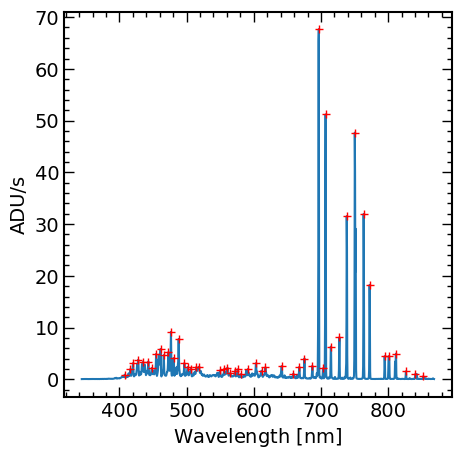

In [38]:
delta = 20 # window size [px]

# Select isolated lines
peaks,_ = find_peaks(calib_spec, prominence = 0.5, distance = delta/2) 
plt.plot(lams, calib_spec)
plt.plot(lams[peaks], calib_spec[peaks],'r+')
plt.xlabel('Wavelength [$\\rm nm$]')
plt.ylabel('ADU/s')

amplitudes = np.zeros(len(peaks))
cutout = np.zeros((len(peaks),2*delta+1))
Fs, freqs = np.zeros((len(peaks),2*delta+1),dtype='complex'), np.zeros((len(peaks),2*delta+1))
dlams = lams[1:] - lams[:-1]  # delta lambda per pixel [nm]
for i, peak in enumerate(peaks):
    lb, ub = peak-delta, peak+delta+1
    amplitudes[i] = calib_spec[peak]
    cutout[i] = calib_spec[lb:ub]/amplitudes[i] #normalized with peak amplitudes
    Fs[i] = np.fft.fftshift(np.fft.fft(cutout[i])) #fourier transform
    #delta lambda changes slowly, assumed as constant within short interval
    freqs[i] = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(2*delta+1,d=dlams[peak])) # unit : cycles/nm
amplitudes/=np.max(amplitudes) # normalization

# fit instrumental profile
F_1d, freq_1d = Fs.reshape(-1), freqs.reshape(-1)
A_1d = np.abs(F_1d)
# sorting
idx = np.argsort(freq_1d)
freq_1d, A_1d = freq_1d[idx], A_1d[idx]

# k binning
delta_k = 0.1 # Angstom^-1
if WAVELENGTH_UNIT=='nm': delta_k*=10.0
    
kbins = np.arange(delta_k/2,freq_1d[-1]+delta_k, delta_k)
nbins = len(kbins)-1
kcen = 0.5*(kbins[1:]+kbins[:-1])
A_med = np.full(nbins, np.nan)
A_std = np.full(nbins, np.nan)

for j in range(nbins):
    bin_idx = (freq_1d >= kbins[j]) & (freq_1d < kbins[j+1])
    if np.any(bin_idx):
        _, A_med[j], A_std[j] = sigma_clipped_stats(A_1d[bin_idx], sigma = 2)

valid = ~np.isnan(A_med)
k_fit   = kcen[valid]
A_fit   = A_med[valid]
sigma_A = A_std[valid]

n_iter = 3

delta_lambda = 0.8
sig_k0 = 1/delta_lambda*2*np.sqrt(2*np.log(2))
p0 = np.array([0.5,0,sig_k0])
p_inst,_ = curve_fit(gaussian, k_fit, A_fit, sigma = sigma_A, p0 = p0,
                     bounds = ((0,-1e-2,0),(20,1e-2,20))) #initial fit 
for _ in range(n_iter): #fitting profile iteratively
    res_mask = sigma_clip(A_1d-gaussian(freq_1d,*p_inst),sigma=3).mask #sigma_clipping
    p_inst, pcov = curve_fit(gaussian, freq_1d[~res_mask],A_1d[~res_mask],bounds = ((0,-1e-2,0),(5,1e-2,20)))
    
perr = np.sqrt(np.diag(pcov))
    
#instrumental broadening - line width
delta_lambda = 1/p_inst[2]*2*np.sqrt(2*np.log(2))
e_delta_lambda = perr[2]/p_inst[2]**2*2*np.sqrt(2*np.log(2))
print(f'{delta_lambda:.3f}+/-{e_delta_lambda:.3f}')

# Spectral resolution R
lam_pivot = 5000  # Anstrom
if WAVELENGTH_UNIT=='nm': lam_pivot/=10.0
    
R = lam_pivot / delta_lambda 
e_R = lam_pivot * e_delta_lambda / delta_lambda**2
print(f'R({lam_pivot} nm)={R:.1f}+/-{e_R:.1f}')

R(500 nm)=637.9+/-8.7


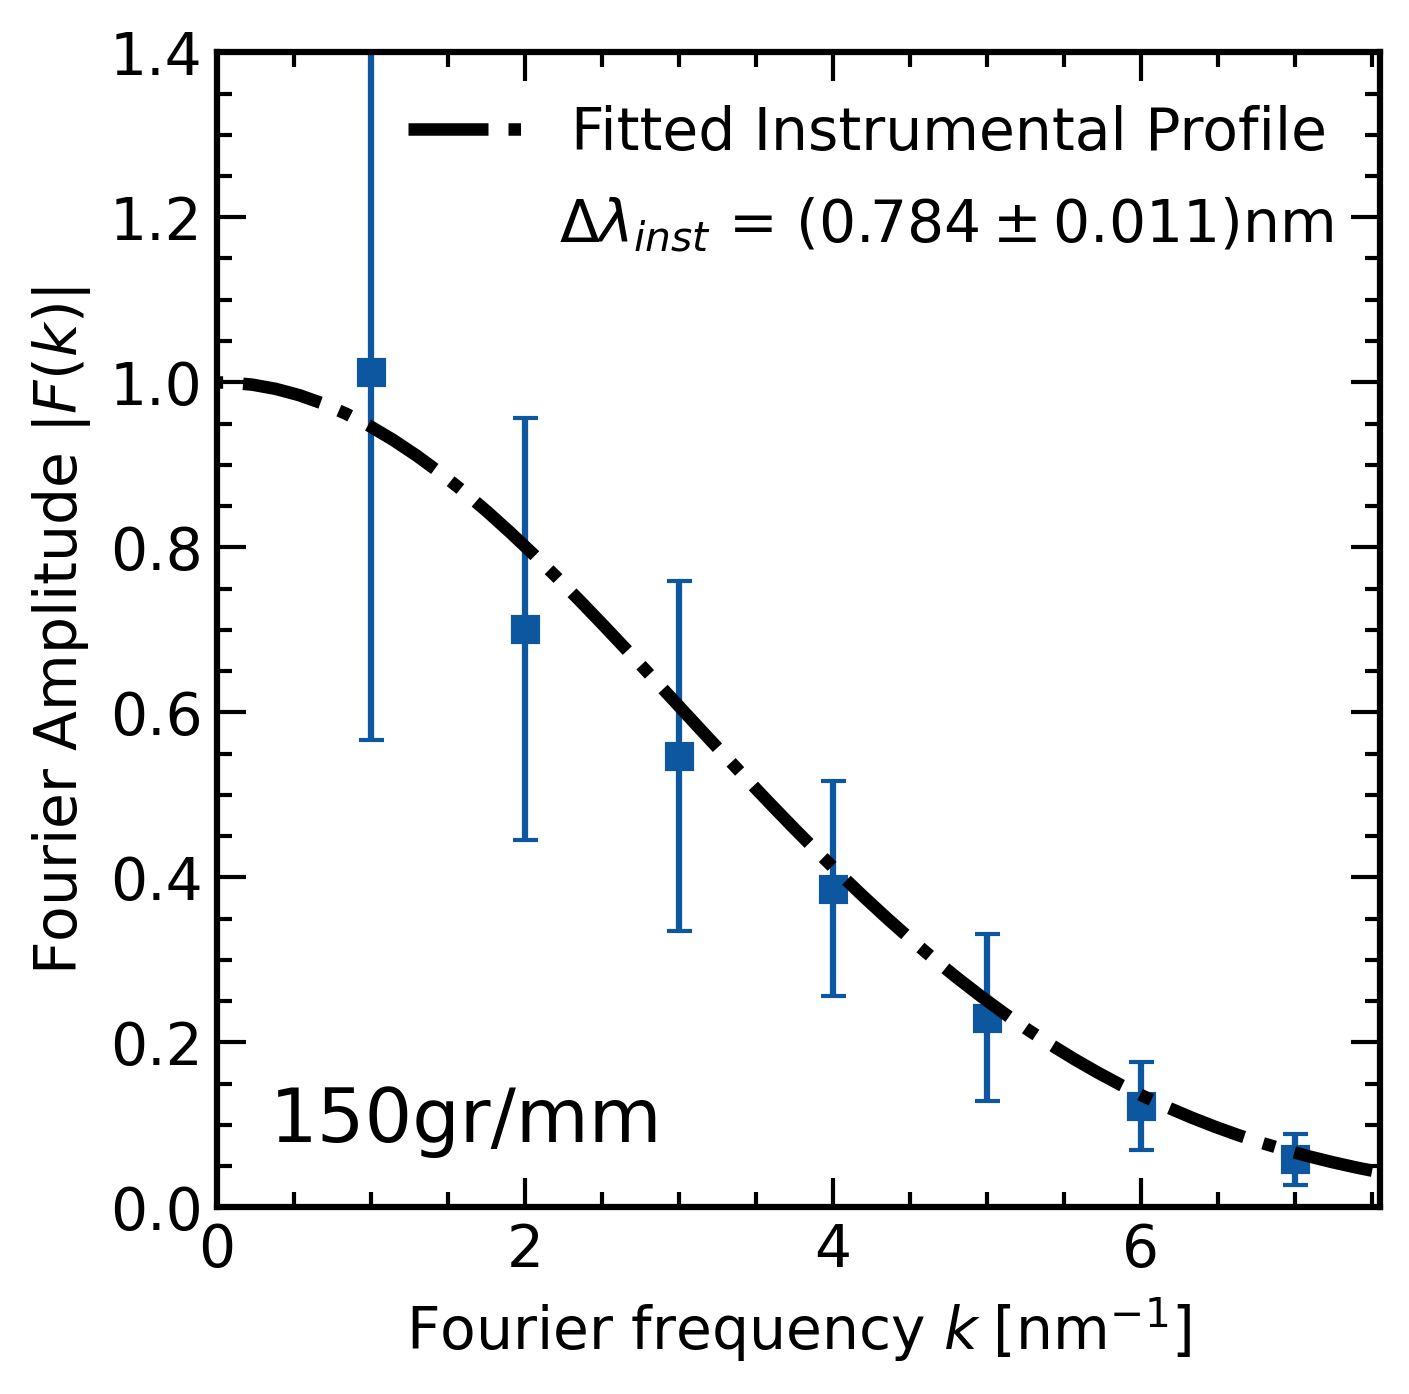

In [39]:
# Spectral resolution R
lam_pivot = 500  # nm
R = lam_pivot / delta_lambda 
e_R = lam_pivot * e_delta_lambda / delta_lambda**2
print(f'R({lam_pivot} nm)={R:.1f}+/-{e_R:.1f}')

fig, ax = plt.subplots(ncols = 1, nrows = 1,figsize = (5,5), dpi = 300)
fs = np.linspace(-2*np.pi*0.48/max(dlams),2*np.pi*0.48/max(dlams),100)
inst_profile = gaussian(fs, *p_inst)
norm = p_inst[0]

ax.errorbar(k_fit, A_fit/norm, yerr = sigma_A/norm, 
            color = cm.Blues(0.85), marker = 's', ls = 'None', capsize = 3)

#plt.plot(freq_1d[res_mask],A_1d[res_mask]/norm,'rx')
ax.plot(fs,inst_profile/norm,ls='-.',color='k',lw=3,label='Fitted Instrumental Profile', zorder = 10)
#plt.xscale('log')
#plt.yscale('log')
ax.set_xlim(0,fs[-1])
ax.set_ylim(0,1.4)
ax.text(fs[-1]*0.96,1.17,s='$\\Delta \\lambda_{inst}$ = '+f'$({delta_lambda:.3f}\pm{e_delta_lambda:.3f})\\rm nm$',horizontalalignment='right')
ax.text(fs[-1]*0.045,0.08,s=f'{grating}/mm',fontsize=18)
ax.set_xlabel('Fourier frequency $k\;[\\rm nm^{-1}]$')
ax.set_ylabel('Fourier Amplitude $|F(k)|$')
plt.legend()

#plt.savefig(fig_path / 'On-Sky Test' / 'instrumental_profile' / f'instrumental_broadening_{grating}.png',dpi=300,bbox_inches='tight')

In [40]:
delta_lambda, e_delta_lambda = 0.194, 0.003 #nm
lam_pivot = 500 #nm
R = lam_pivot / delta_lambda 
e_R = lam_pivot * e_delta_lambda / delta_lambda**2
print(f'R({lam_pivot} nm)={R:.1f}+/-{e_R:.1f}')

R(500 nm)=2577.3+/-39.9


# Flux Calibration

In [42]:
#Wavelength range
cpix = 50 #recommends you to cutoff zero-flux range(lower limit of spectroscope)
clam = lams[cpix]
print(f"cut-off:{clam:.4f}nm")
norm_sci = sci_spec#/sflat
pixel_s = pixel[cpix:]
lams_s, sci_spec_s, norm_sci_s = lams[lams>=clam], sci_spec[lams>=clam], norm_sci[lams>=clam]
#Interpolation
std_deg = 500
p_std = np.polynomial.Chebyshev.fit(std_lam, std_flux, deg=std_deg)
sstd = p_std(lams_s)

cut-off:363.9144nm


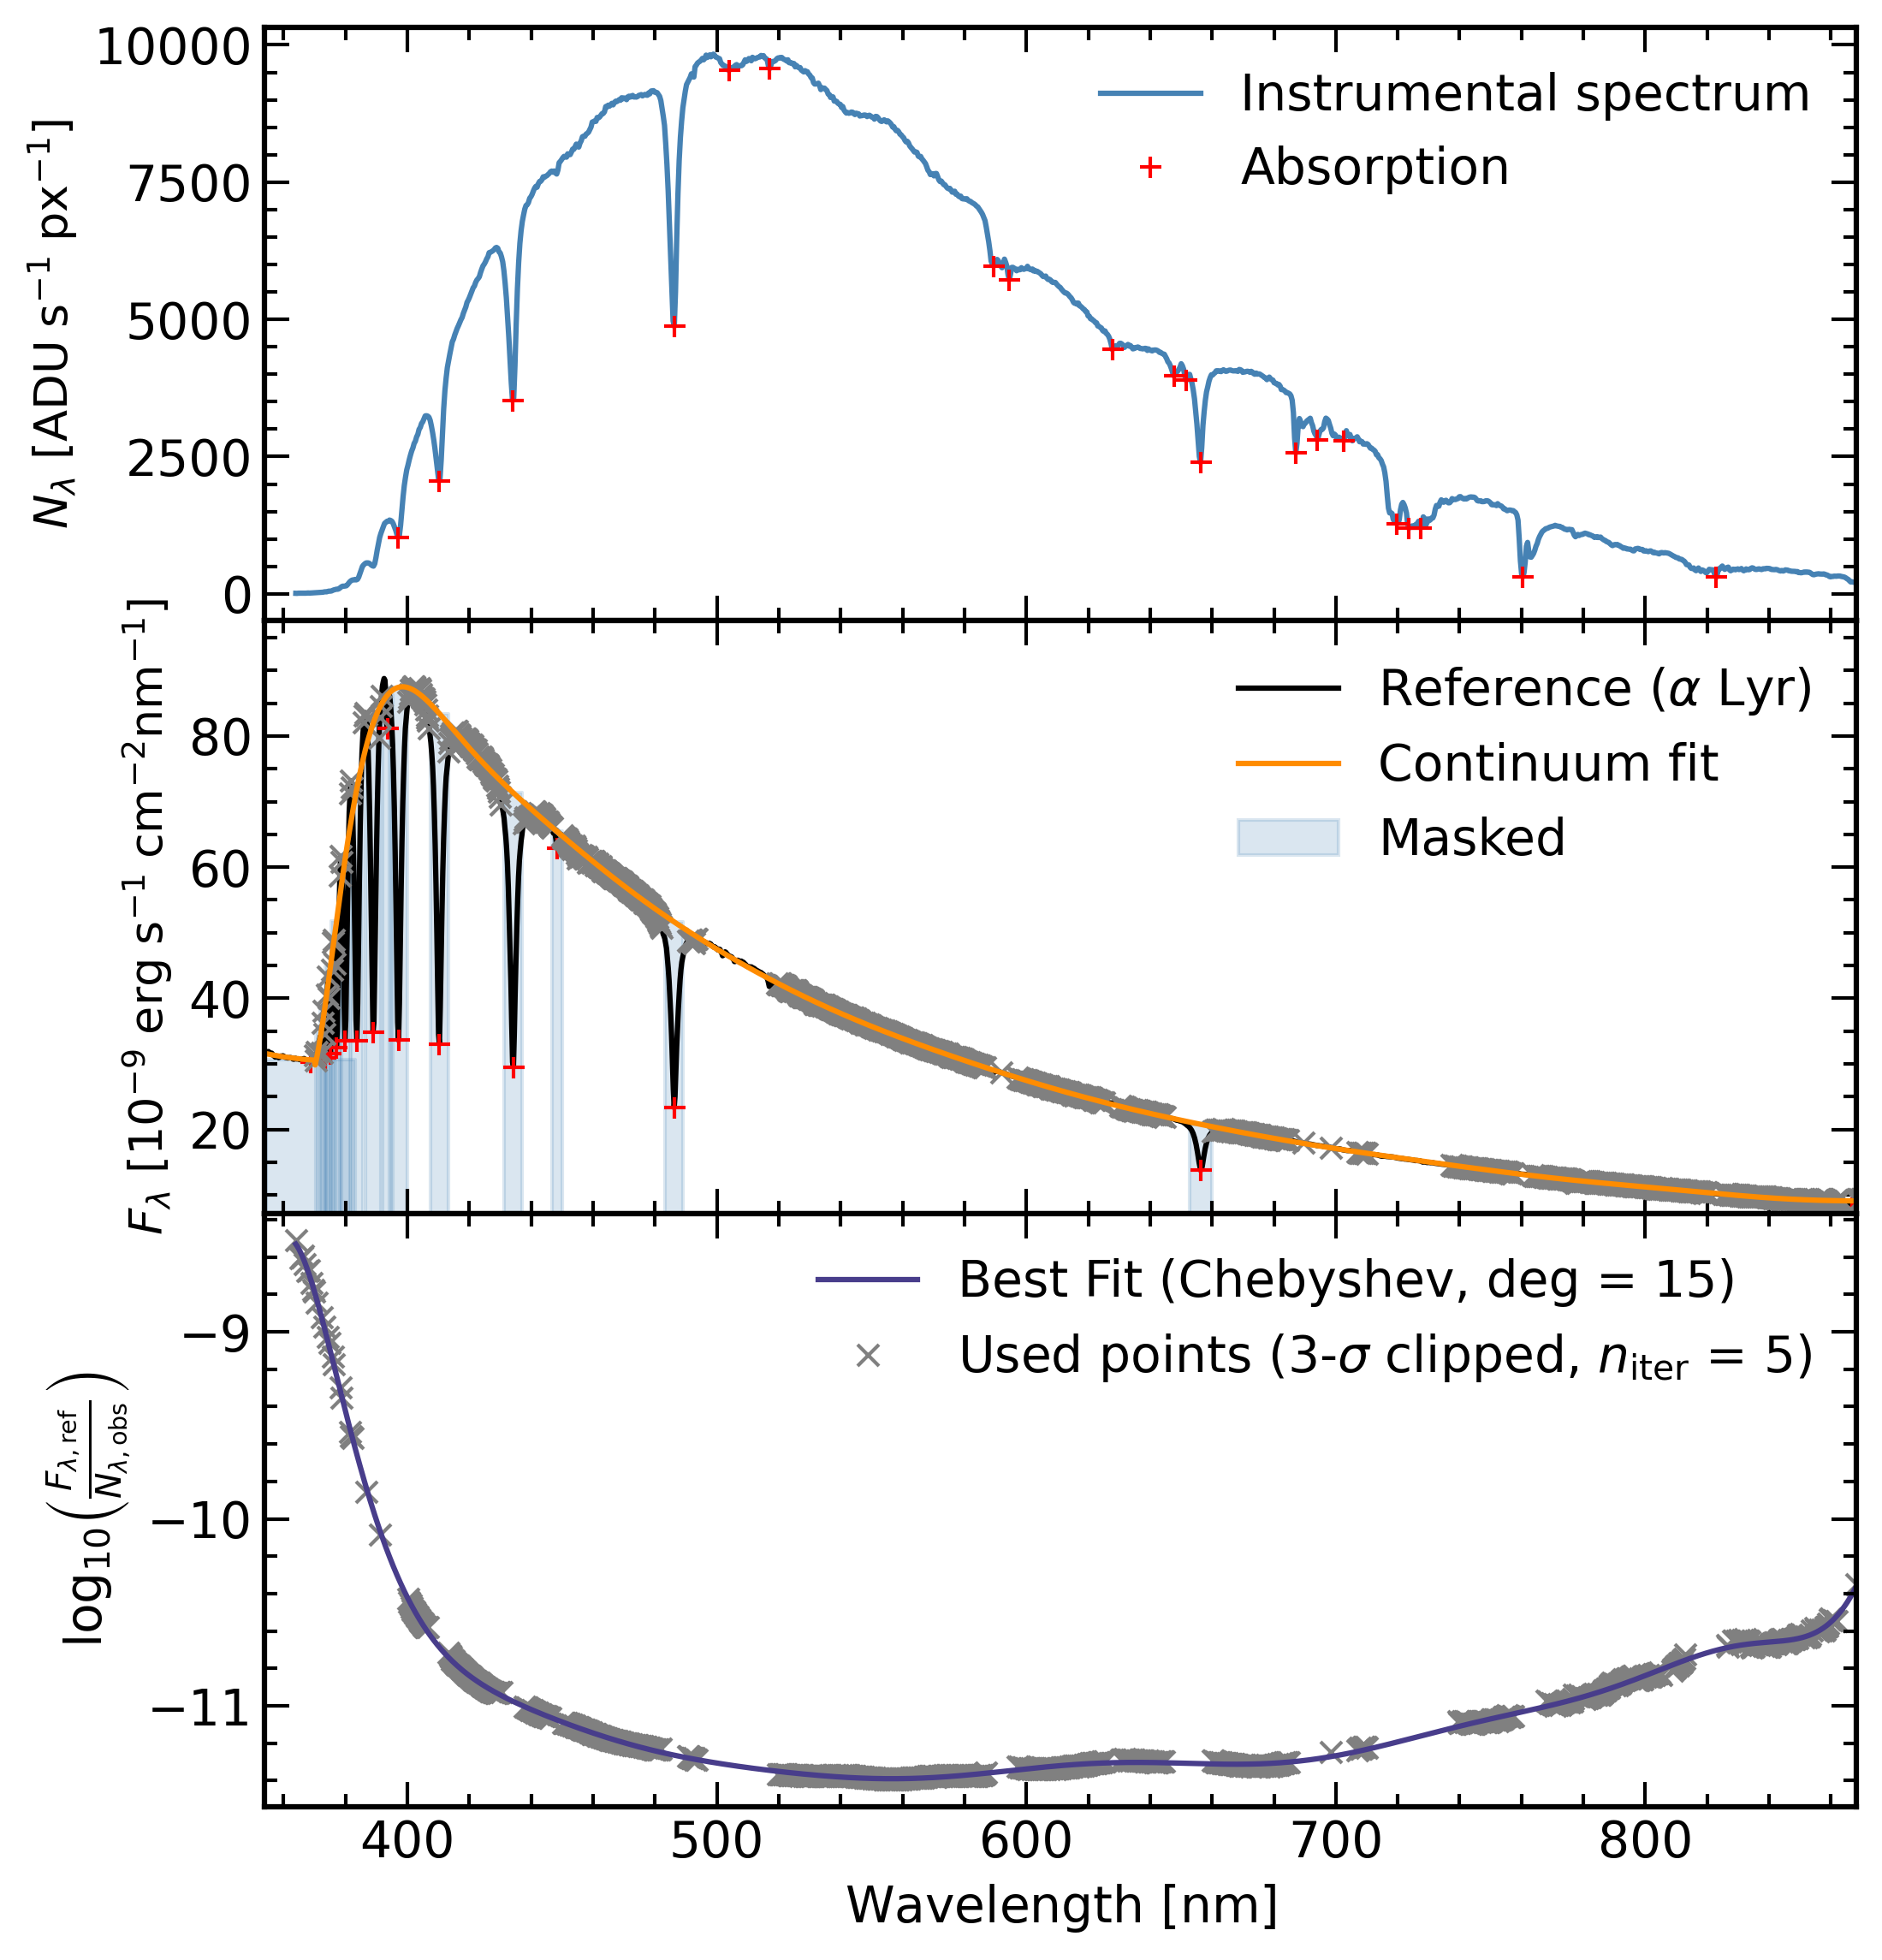

In [45]:
#Peak Detection
peaks_sci, _ = find_peaks(-sci_spec_s/max(sci_spec_s),distance=10,prominence=0.01)
peaks_std, _ = find_peaks(-std_flux/max(std_flux),distance=4,prominence=0.01)

#Width of Absorption line(in pixel)
wfactor = 1.5
wfactor_low = 2
widx_sci = np.maximum(4,peak_widths(-sci_spec_s, peaks_sci, rel_height=0.5)[0]).astype('int') 
widx_std = np.maximum(4,peak_widths(-std_flux, peaks_std, rel_height=0.5)[0]).astype('int')

psci = np.vstack([lams_s[peaks_sci],lams_s[peaks_sci+widx_sci]-lams_s[peaks_sci]]).T
pstd = np.vstack([std_lam[peaks_std],std_lam[peaks_std+widx_std]-std_lam[peaks_std]]).T
dlam_std = std_lam[1]-std_lam[0]

# ============ Spectral features masking =============
# Mask absorption lines appearing at rather observation or reference spectra
lam_break = 3700
lam_lowres = 3950
if WAVELENGTH_UNIT=='nm': lam_break/=10.0; lam_lowres/=10.0
mask_sci, mask_std = np.ones(len(lams_s),dtype='bool'), np.ones(len(std_lam),dtype='bool')
mask_std[std_lam<lam_break] = False
for peaks in [psci, pstd]:
    for i, peak in enumerate(peaks):
        if peak[0]<lam_lowres:
            lb = (peaks[i-1,0]+peak[0])/2 + wfactor_low*dlam_std
            ub = (peaks[i+1,0]+peak[0])/2 - wfactor_low*dlam_std
        else:
            lb = max(lams_s[0], peak[0]-peak[1]*wfactor)
            ub = min(lams_s[-1], peak[0]+peak[1]*wfactor)
        mask_sci[(lams_s>lb)&(lams_s<ub)] = False 
        mask_std[(std_lam>lb)&(std_lam<ub)] = False #only for absorptions at standard spectra

# ============ Continuum function ===============
#interpolation for matching data dimension        
std_deg= 20
n_iter = 3

std_cont_flux, std_cont_lam = std_flux[mask_std], std_lam[mask_std]
for i in range(n_iter): #fitting profile iteratively
    if i>0: 
        res_mask_cont = sigma_clip(std_cont_flux-f_cont_std(std_cont_lam),sigma=3).mask #sigma_clipping
        std_cont_flux, std_cont_lam = std_cont_flux[~res_mask_cont], std_cont_lam[~res_mask_cont]
    f_cont_std = np.polynomial.Chebyshev.fit(std_cont_lam, std_cont_flux, deg=std_deg) #initial fit 

mask_std_break = (std_lam<lam_break)
mask_break = (lams_s<lam_break)
f_break = np.polynomial.Chebyshev.fit(std_lam[mask_std_break], std_flux[mask_std_break], deg=2)

#fitted continuum(flux below balmer break+Spectrum)
def f_continuum(lam):
    mask = (lam<lam_break)
    return np.concatenate([f_break(lam[mask]),f_cont_std(lam[~mask])])

ref_lam = lams_s[mask_sci]
sstd_cont = f_continuum(ref_lam) #dimension matching for observed spectrum
ratio = np.array(np.abs(sstd_cont/norm_sci_s[mask_sci])) #Flux / Normalized Counts ratio
logRatio = np.log10(ratio) #Smoothing with logarithm

# ===========  Response function ==============
n_iter = 5
res_deg = 15 #order of fitting polynomial for response function
spl = np.polynomial.Chebyshev.fit(ref_lam,logRatio,deg=res_deg)
for _ in range(n_iter):
    res_mask = sigma_clip(logRatio-spl(ref_lam), sigma = 3).mask
    spl = np.polynomial.Chebyshev.fit(ref_lam[~res_mask],logRatio[~res_mask],deg=res_deg)
sens = spl(lams_s)

# ================ Visualization =================
fig,ax = plt.subplots(3,1,figsize=(8,9), dpi=300)
ax[0].plot(lams_s,norm_sci_s, label = 'Instrumental spectrum', color = 'steelblue')
ax[0].plot(lams_s[peaks_sci],norm_sci_s[peaks_sci],'r+', label = 'Absorption')
ax[0].set_xlim(lams_s[0]-10,lams_s[-1])
ax[0].set_ylabel('$N_\\lambda$ [$\\rm ADU\;s^{-1}\;px^{-1}$]', fontsize = 13)
ax[0].legend()

ax[1].plot(std_lam,std_flux*1e9, color='k', label = 'Reference ($\\alpha$ Lyr)')
ax[1].plot(std_lam[peaks_std],std_flux[peaks_std]*1e9,ls='None',marker='+',color='red')
ax[1].plot(std_lam[mask_std],std_flux[mask_std]*1e9,ls='None',marker='x',color='gray')
ax[1].plot(std_lam,f_continuum(std_lam)*1e9,label='Continuum fit',color='darkorange')
#ax[1].axvline(clam, ls='dotted',color='k',label='Cut-off')

#Absorption feature mask
for peak in pstd:
    lb = max(std_lam[0], peak[0]-peak[1]*wfactor)
    ub = min(std_lam[-1], peak[0]+peak[1]*wfactor)
    ax[1].fill_between([lb,ub],f_continuum((lb+ub)/2)*1e9,alpha=0.2,color='steelblue')
ax[1].fill_between([-1,0],0,alpha=0.2,color='steelblue',label='Masked')

ax[1].set_xlim(lams_s[0]-10,lams_s[-1])
#plt.xlim(std_lam[0],5000)
ax[1].set_ylim(min(std_flux)*1e9,max(std_flux)*1.1*1e9)
ax[1].set_ylabel('$F_\\lambda$ [$\\rm 10^{-9}\;erg\;s^{-1}\;cm^{-2} nm^{-1}$]', fontsize = 13)
#ax[1].set_xlabel('Wavelength [$\\rm nm$]')
ax[1].legend()#bbox_to_anchor=(0.99,0.83))

ax[2].plot(lams_s,sens,label=f'Best Fit (Chebyshev, deg = {res_deg})',color='darkslateblue',zorder=1)
ax[2].plot(ref_lam[~res_mask],logRatio[~res_mask],marker='x',color='gray',ls='None',
         label=f'Used points (3-$\sigma$ clipped, $n_{{\\rm iter}}$ = {n_iter})', zorder=0)
ax[2].set_xlim(lams_s[0]-10,lams_s[-1])
ax[2].set_xlabel('Wavelength [$\\rm nm$]')
ax[2].set_ylabel('$\\text{log}_{10} \\left( \\frac{F_{\\lambda,\\rm ref}}{N_{\\lambda,\\rm obs}}\\right)$')
ax[2].legend()


plt.subplots_adjust(hspace=0)
#plt.tight_layout()
#plt.savefig(fig_dir / 'flux_cal_nm.png',dpi=300, bbox_inches="tight")